## Amazon Rekognition Video : Face and Emotion Detection 

In this workshop we will explore what we just reviewed on Amazon Rekognition Video capabilities for stored video. We will look at 

1. Set up , Permissions
2. Steps involved 
3. Face Detection API 
4. Results 
5. Post Processing and Analysis

Note that what we demonstrate here can quickly be complied into a lambda function that can continue to keep track of the job and alert or process the results when rekognition is done. However for tutorial purposes, we will do this in notebook for immediate rendering of output and results.

The purpose of use the API in reference is to measure engagement and faces provide the best measure of engagement. The API we will look at in the next workshop is people pathing API, so we can track individuals across the length of the video

#### Let's start with some basic libraries 

In [1]:
import boto3
import json
import logging
import sys


In [2]:

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
rek=boto3.client('rekognition')

#### Convenience Functions

I have created come convenience functions here modified from documentation for the sake of this workshop, these can also be used inside lambda functions with minor modifications

we have functions here to 

1. create a notification channel (SNS, SQS, IAM Role)
2. Poll Notification Channel for job completion 
3. get results from the rekognition after the completion of the job 
4. upload a file to s3 in json format
5. delete resources created by step 1

In [3]:
def create_notification_channel(resource_name):
    """
    Creates a notification channel used by Amazon Rekognition to notify subscribers
    that a detection job has completed. The notification channel consists of an
    Amazon SNS topic and an Amazon SQS queue that is subscribed to the topic.

    After a job is started, the queue is polled for a job completion message.
    Amazon Rekognition publishes a message to the topic when a job completes,
    which triggers Amazon SNS to send a message to the subscribing queue.

    As part of creating the notification channel, an AWS Identity and Access
    Management (IAM) role and policy are also created. This role allows Amazon
    Rekognition to publish to the topic.

    :param resource_name: The name to give to the channel resources that are
                          created.
    :param iam_resource: A Boto3 IAM resource.
    :param sns_resource: A Boto3 SNS resource.
    :param sqs_resource: A Boto3 SQS resource.
    """
    print("Creating notification channel from Amazon Rekognition to Amazon SQS.")
    iam_resource = boto3.resource('iam')
    sns_resource = boto3.resource('sns')
    sqs_resource = boto3.resource('sqs')

    topic = sns_resource.create_topic(Name=resource_name)
    queue = sqs_resource.create_queue(
        QueueName=resource_name, Attributes={'ReceiveMessageWaitTimeSeconds': '5'})
    queue_arn = queue.attributes['QueueArn']

    # This policy lets the queue receive messages from the topic.
    queue.set_attributes(Attributes={'Policy': json.dumps({
        'Version': '2008-10-17',
        'Statement': [{
            'Sid': 'test-sid',
            'Effect': 'Allow',
            'Principal': {'AWS': '*'},
            'Action': 'SQS:SendMessage',
            'Resource': queue_arn,
            'Condition': {'ArnEquals': {'aws:SourceArn': topic.arn}}}]})})
    topic.subscribe(Protocol='sqs', Endpoint=queue_arn)

    # This role lets Amazon Rekognition publish to the topic. Its Amazon Resource
    # Name (ARN) is sent each time a job is started.
    try:
        role = iam_resource.create_role(
            RoleName=resource_name,
            AssumeRolePolicyDocument=json.dumps({
                'Version': '2012-10-17',
                'Statement': [
                    {
                        'Effect': 'Allow',
                        'Principal': {'Service': 'rekognition.amazonaws.com'},
                        'Action': 'sts:AssumeRole'
                    }
                ]
            })
        )
        policy = iam_resource.create_policy(
            PolicyName=resource_name,
            PolicyDocument=json.dumps({
                'Version': '2012-10-17',
                'Statement': [
                    {
                        'Effect': 'Allow',
                        'Action': 'SNS:Publish',
                        'Resource': topic.arn
                    }
                ]
            })
        )
        role.attach_policy(PolicyArn=policy.arn)
    except Exception as e:
        print(e)
    return {'RoleArn': role.arn, 'SNSTopicArn': topic.arn}, {'Role':role,'queue':queue, 'topic':topic}


def delete_notification_channel(resource_dict):
    """
    Deletes all of the resources created for the notification channel.

    """
    role=resource_dict['Role']
    topic=resource_dict['topic']
    queue=resource_dict['queue']
    for policy in role.attached_policies.all():
        role.detach_policy(PolicyArn=policy.arn)
        policy.delete()
    role.delete()
    print("Deleted role %s.", role.role_name)
    role = None
    queue.delete()
    print("Deleted queue %s.", queue.url)
    queue = None
    topic.delete()
    print("Deleted topic %s.", topic.arn)
    topic = None

def poll_notification(job_id,queue):
    """
    Polls the notification queue for messages that indicate a job has completed.

    :param job_id: The ID of the job to wait for.
    :return: The completion status of the job.
    """
    status = None
    job_done = False
    while not job_done:
        messages = queue.receive_messages(
            MaxNumberOfMessages=1, WaitTimeSeconds=5)
        print("Polled queue for messages, got %s.", len(messages))
        if messages:
            body = json.loads(messages[0].body)
            message = json.loads(body['Message'])
            if job_id != message['JobId']:
                raise RuntimeError
            status = message['Status']
            print("Got message %s with status %s.", message['JobId'], status)
            print(message)
            messages[0].delete()
            job_done = True
    return status

In [4]:
def StartFaceDetection(bucket, video,role_arn,topic_arn):
    print('Video novo sendo processado: ', video, ', ', bucket)
    response = rek.start_face_detection(Video={'S3Object': {'Bucket': bucket, 'Name': video}},
                                        FaceAttributes='ALL',
                                        NotificationChannel={'RoleArn': role_arn, 'SNSTopicArn': topic_arn})
    startJobId = response['JobId']
    print('Start Job Id: ' + startJobId)
    return startJobId


In [7]:
def GetFaceDetectionResults(start_job_id):
    max_results = 10
    pagination_token = ''
    finished = False
    content = []

    while not finished:
        response = rek.get_face_detection(JobId=start_job_id,
                                          MaxResults=max_results,
                                          NextToken=pagination_token)
        for FaceDetection in response['Faces']:
            reaction = {}
            face = FaceDetection['Face']
            reaction['Timestamp'] = FaceDetection['Timestamp']
            reaction['Confidence'] = face['Confidence']
            for instance in face['Emotions']:
                reaction[instance['Type']] = instance['Confidence']
                content.append(reaction)
        if 'NextToken' in response:
            pagination_token = response['NextToken']
        else:
            finished = True
    return content


In [12]:
def UploadVideoResults(content, bucket, video_name):
    s3=boto3.client('s3')
    video_name = video_name.replace('.mp4', '.json')
    key = f'analyzed_videos/{video_name}'
    print('Uploaded Results to S3')
    s3.put_object(
        Body=json.dumps(content),
        Bucket=bucket,
        Key=key
    )

### Step 1

1. Create a SNS Topic  - for Rekognition to send update on a video job
2. Create Iam role and - Rekognition to have access to s3
3. create a SQS queue  - Queue to receive a message from SNS Topic 



In [33]:
arns, step_details=create_notification_channel('mathematica-demo-rek')

Creating notification channel from Amazon Rekognition to Amazon SQS.


In [34]:
### make sure the delete code can delete in case you want to confirm 
# delete_notification_channel(step_details)

### Step 2 
Make a call to rekognition using the bucket, video file and arns from step 1 to SNS Topic and Iam Role, if you don't specify FaceAttributes='ALL' you will only get facial landmark details, if you want to get emotions and other details, use this param

In [37]:
jobId=StartFaceDetection(bucket='mathematica-demo-video', video='iPad-1080p-Swivel.mp4',role_arn=arns['RoleArn'],topic_arn=arns['SNSTopicArn'])

Video novo sendo processado:  iPad-1080p-Swivel.mp4 ,  mathematica-demo-video
Start Job Id: 60d6568449775e9cabbc57f3e27661fa00b6a3dad6432c5cabe66f6a4cc0e9e5


### Step 3
Now that we have a job id, we will poll the sqs for completion message, it will run on a loop checking the status and returning when the job is done

In [38]:
poll_notification(job_id=jobId,queue=step_details['queue'])

'SUCCEEDED'

### Step 4 
Let's get the results write them to json file and store them in s3 for further analysis of emotions through out the video 

In [8]:
content=GetFaceDetectionResults('60d6568449775e9cabbc57f3e27661fa00b6a3dad6432c5cabe66f6a4cc0e9e5')

In [13]:
UploadVideoResults(content, bucket='mathematica-demo-video', video_name='iPad-1080p-Swivel.mp4')

Uploaded Results to S3


### Step 5
Let's get a global sense of emotions throughout the video , what is most expressed what is least expressed, Note that as we gather and store the results above, we have ensured to attach emotions to each face.

In [16]:
%%bash
mkdir -p analyzed
cd analyzed
aws s3 cp s3://mathematica-demo-video/analyzed_videos/ . --recursive
ls -lah

download: s3://mathematica-demo-video/analyzed_videos/iPad-1080p-Swivel.json to ./iPad-1080p-Swivel.json
total 41M
drwxrwxr-x 2 ec2-user ec2-user 4.0K Oct 20 22:28 .
drwxrwxr-x 5 ec2-user ec2-user 4.0K Oct 20 22:28 ..
-rw-rw-r-- 1 ec2-user ec2-user  41M Oct 20 22:26 iPad-1080p-Swivel.json


In [17]:
video_file = 'iPad-1080p-Swivel.json'  # CHANGE THIS!!!

with open(f'analyzed/{video_file}', 'r') as myfile:
    data = myfile.read()
content = json.loads(data)

In [19]:
import pandas as pd

In [20]:
df = pd.read_json(data)
df.head()

,Timestamp,Confidence,CALM,SURPRISED,ANGRY,FEAR,HAPPY,CONFUSED,SAD,DISGUSTED
0,0,99.986557,58.66391,20.243938,9.277607,3.179061,3.166966,2.663893,1.44661,1.358017
1,0,99.986557,58.66391,20.243938,9.277607,3.179061,3.166966,2.663893,1.44661,1.358017
2,0,99.986557,58.66391,20.243938,9.277607,3.179061,3.166966,2.663893,1.44661,1.358017
3,0,99.986557,58.66391,20.243938,9.277607,3.179061,3.166966,2.663893,1.44661,1.358017
4,0,99.986557,58.66391,20.243938,9.277607,3.179061,3.166966,2.663893,1.44661,1.358017


In [21]:
df[['SURPRISED', 'HAPPY', 'CALM', 'CONFUSED','SAD', 'FEAR', 'ANGRY', 'DISGUSTED']].max()


SURPRISED    97.657845
HAPPY        99.979965
CALM         99.936035
CONFUSED     98.525314
SAD          99.953308
FEAR         99.541855
ANGRY        99.928322
DISGUSTED    98.982307
dtype: float64

In [22]:
df.columns


Index(['Timestamp', 'Confidence', 'CALM', 'SURPRISED', 'ANGRY', 'FEAR',
       'HAPPY', 'CONFUSED', 'SAD', 'DISGUSTED'],
      dtype='object')


#### Data Visualization
Having the datasets is only the first part of the insights process. Tables are not human-friendly when you have a lot of different lines and columns. Using data visualization techniques (dataviz) is a more efficient way of understanding patterns, behaviors, etc.
First, let's define some default configurations for new figures:

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [28]:
plt.rcParams['figure.figsize'] = (20, 8)
sns.set()

**Timeline**
As our first graph, we will investigate how the sentiments behaved in the timeline.

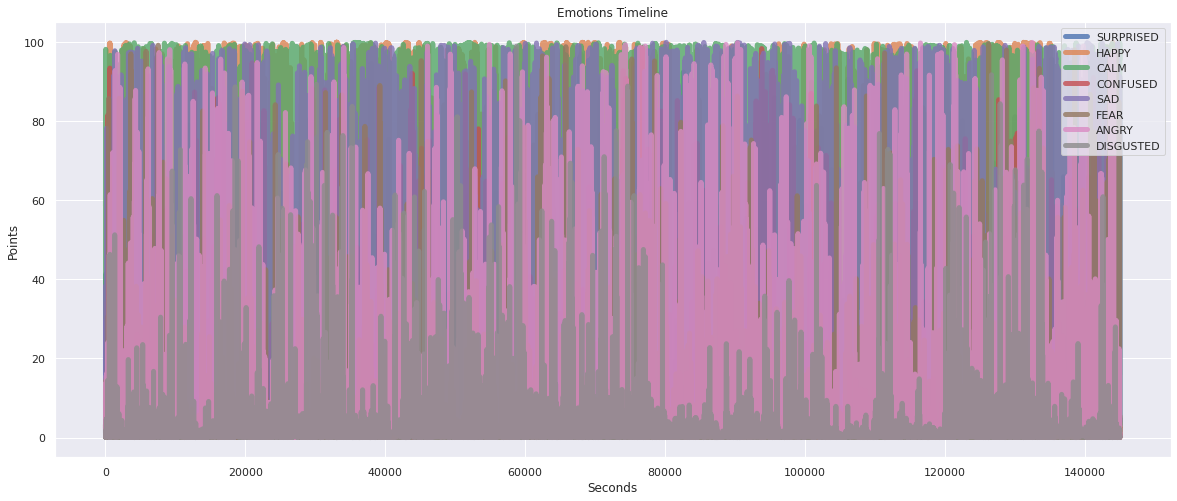

In [40]:
plt.figure(figsize=[20, 8])
selected = ['SURPRISED', 'HAPPY', 'CALM', 'CONFUSED','SAD', 'FEAR', 'ANGRY', 'DISGUSTED']
for sentiment in selected:
    plt.plot(df[sentiment], label=sentiment, linewidth=5, alpha=0.8)
plt.legend()
plt.title('Emotions Timeline')
plt.xlabel('Seconds')
plt.ylabel('Points')
plt.show()

It is possible to see the sentiments rising and lowering during the video, but the graph is a little bit confusing. Our first change will be remove the minor sentiments, visualizing only the most important sentiment at that very moment.
We create a dataframe using the Timestamp as our index and the column name with the max value of each line as the value to be printed

In [41]:

tmp_df = df[['Timestamp'] + selected].set_index('Timestamp').idxmax(axis=1)
tmp_df = pd.DataFrame(tmp_df)
tmp_df.columns = ['Sentiment']
tmp_df['IDXSentiment'] = tmp_df['Sentiment'].apply(list(set(tmp_df['Sentiment'])).index)
tmp_df.sample(10)

,Sentiment,IDXSentiment
Timestamp,,
455036,CALM,1
2530753,CALM,1
402501,SAD,5
2232721,CALM,1
1108939,CALM,1
1152968,CALM,1
993595,SAD,5
365476,HAPPY,3
1525050,ANGRY,4


Now, for each timestamp, we have the name of the predominant sentiment and an index for this sentiment.


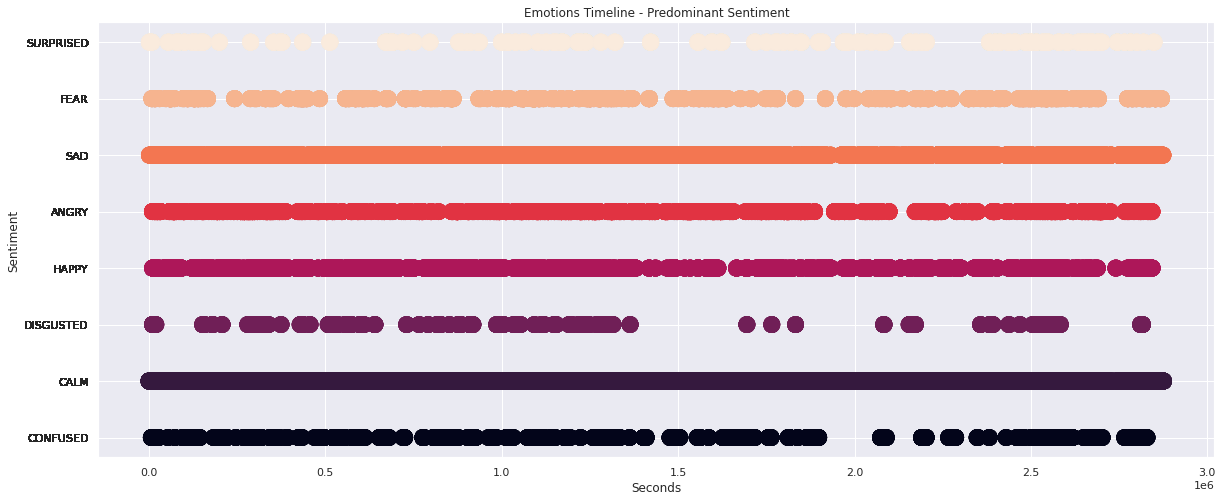

In [42]:
plt.scatter(tmp_df.index, tmp_df['IDXSentiment'], c=tmp_df['IDXSentiment'], s=250)
plt.yticks(tmp_df['IDXSentiment'], tmp_df['Sentiment'])
plt.title('Emotions Timeline - Predominant Sentiment')
plt.xlabel('Seconds')
plt.ylabel('Sentiment')
plt.show()


There are other ways of using colors to match behaviors during time<br>
Let's use an One Hot Encoding approach to get numeric data from classes:


In [43]:
onehot_df = pd.get_dummies(tmp_df['Sentiment'])
onehot_df = onehot_df.reset_index()
onehot_df['Sentiment'] = tmp_df['Sentiment'].values
onehot_df['IDXSentiment'] = tmp_df['IDXSentiment'].values
onehot_df.head()

,Timestamp,ANGRY,CALM,CONFUSED,DISGUSTED,FEAR,HAPPY,SAD,SURPRISED,Sentiment,IDXSentiment
0,0,0,1,0,0,0,0,0,0,CALM,1
1,0,0,1,0,0,0,0,0,0,CALM,1
2,0,0,1,0,0,0,0,0,0,CALM,1
3,0,0,1,0,0,0,0,0,0,CALM,1
4,0,0,1,0,0,0,0,0,0,CALM,1


And now, we plot the stacked areas using the numerical data from the one hot encoded dataset:


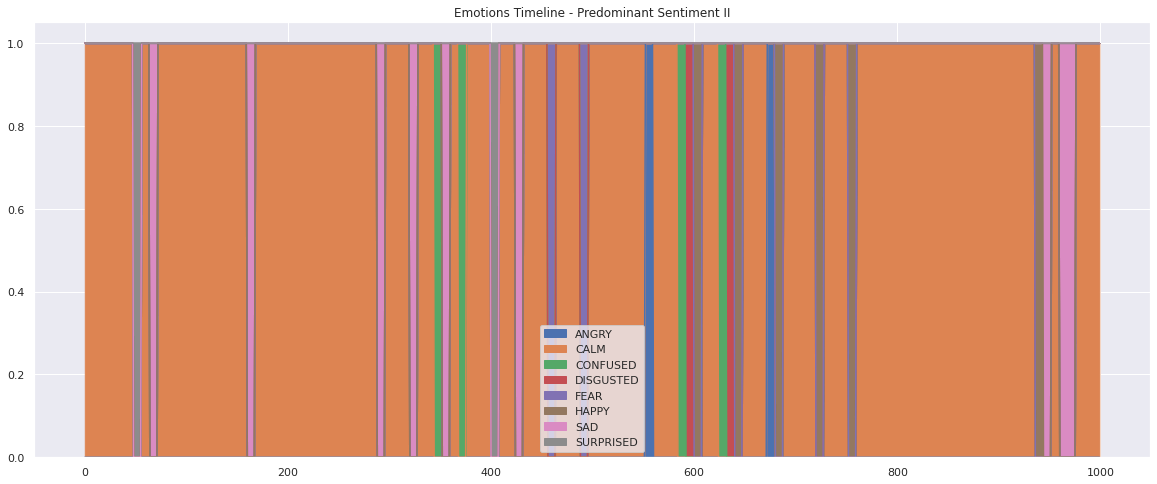

In [49]:
y = onehot_df.drop(['Timestamp', 'IDXSentiment', 'Sentiment'], axis=1)[0:1000]
y.plot(kind='area', stacked=True, sort_columns=True)
plt.title('Emotions Timeline - Predominant Sentiment II')
plt.show()

**That is it!** Now we are able to see and track the sentiment changes during the video.

With these datasets, it is possible to get even more statistics about the videos.

Let's check the distributions:

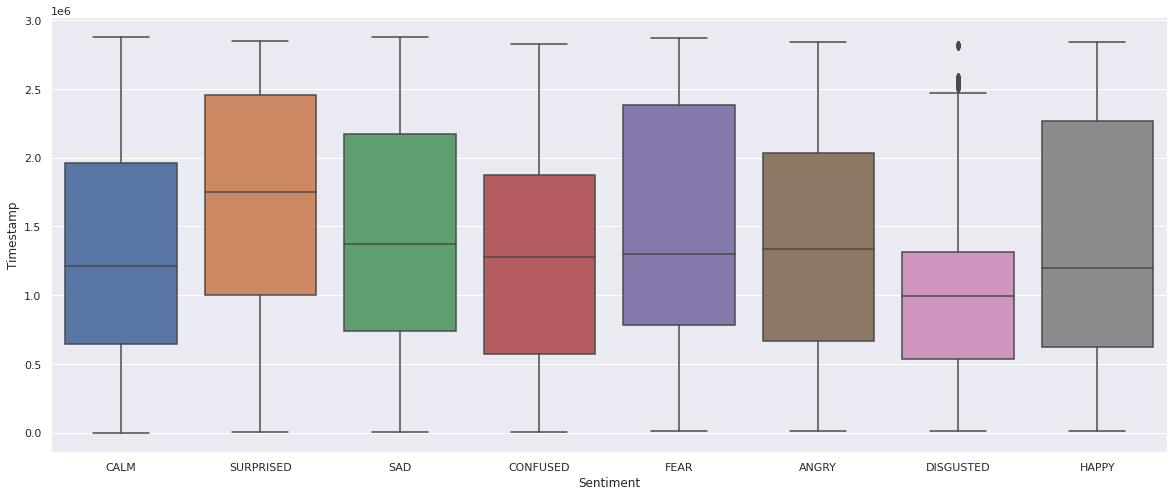

In [51]:

sns.boxplot(x='Sentiment', y='Timestamp', data=tmp_df.reset_index())
plt.show()